In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader

In [2]:
gpu = False
if torch.cuda.is_available():
    device = torch.device("cuda")
    gpu = True
    print("GPU is available")
else:
    device = torch.device("cpu")
    print("GPU is not available")

GPU is available


In [93]:
def process_data(df):
    df = df.drop(columns=['id'], axis=1)
    numeric_cols = df.select_dtypes(include=['number']).columns
    means = df[numeric_cols].mean()
    max_abs = df[numeric_cols].abs().max()
    df[numeric_cols] = (df[numeric_cols] - means) / max_abs * 2
    string_columns = df.select_dtypes(include=['object', 'string']).columns
    df_encoded = pd.get_dummies(df, columns=string_columns, dummy_na=True)
    bool_columns = df_encoded.select_dtypes(include=[bool]).columns
    df_encoded[bool_columns] = df_encoded[bool_columns].astype(int)
    df_encoded = df_encoded.apply(lambda x: x.fillna(x.mean()) if np.issubdtype(x.dtype, np.number) else x)
    return df_encoded, means, max_abs

In [94]:
df_encoded, means, max_abs = process_data(pd.read_csv('data/train.csv'))
df_encoded

,Compartments,Weight Capacity (kg),Price,Brand_Adidas,Brand_Jansport,Brand_Nike,Brand_Puma,Brand_Under Armour,Brand_nan,Material_Canvas,...,Style_Messenger,Style_Tote,Style_nan,Color_Black,Color_Blue,Color_Gray,Color_Green,Color_Pink,Color_Red,Color_nan
0,0.311282,-0.427885,0.409969,0,1,0,0,0,0,0,...,0,1,0,1,0,0,0,0,0,0
1,0.911282,0.603236,-0.167074,0,1,0,0,0,0,1,...,1,0,0,0,0,0,1,0,0,0
2,-0.688718,-0.092416,-0.563172,0,0,0,0,1,0,0,...,1,0,0,0,0,0,0,0,1,0
3,0.511282,-0.339518,-0.010709,0,0,1,0,0,0,0,...,1,0,0,0,0,0,1,0,0,0
4,-0.888718,-0.018710,0.061494,1,0,0,0,0,0,1,...,1,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
299995,0.711282,-0.353279,0.647818,1,0,0,0,0,0,0,...,0,1,0,0,1,0,0,0,0,0
299996,0.111282,0.573546,-0.820706,0,1,0,0,0,0,0,...,0,1,0,0,1,0,0,0,0,0
299997,0.711282,-0.408783,0.400034,0,0,0,1,0,0,1,...,0,0,0,0,0,0,0,1,0,0
299998,-0.888718,-0.790284,0.459729,1,0,0,0,0,0,0,...,0,1,0,0,0,0,0,1,0,0


In [95]:
means, max_abs

(Compartments             5.443590
 Weight Capacity (kg)    18.029994
 Price                   81.411107
 dtype: float64,
 Compartments             10.0
 Weight Capacity (kg)     30.0
 Price                   150.0
 dtype: float64)

In [96]:
class BackpackDataset(Dataset):
    def __init__(self, df):
        # 检查输入是否为 pandas DataFrame
        if not isinstance(df, pd.DataFrame):
            raise ValueError("Input must be a pandas DataFrame")
        
        # 检查是否包含 'Price' 列
        if 'Price' not in df.columns:
            raise ValueError("DataFrame must contain 'Price' column")
        
        # 将特征和目标转换为张量
        self.features = torch.tensor(df.drop(columns=['Price']).values, dtype=torch.float32)
        self.targets = torch.tensor(df['Price'].values, dtype=torch.float32).unsqueeze(1)
    
    def __len__(self):
        return len(self.features)
    
    def __getitem__(self, idx):
        # 直接返回预先转换好的张量
        return self.features[idx], self.targets[idx]

In [97]:
test_size = 5000
train_df, test_df = train_test_split(df_encoded, test_size=test_size, random_state=42)
train_dataset = BackpackDataset(train_df)
test_dataset = BackpackDataset(test_df)

In [98]:
len(train_dataset)

295000

In [108]:
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=512, shuffle=True, num_workers=0, pin_memory=False)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=True, num_workers=0, pin_memory=False)

In [109]:
for x, y in train_dataloader:
    print(x.shape[1])
    break

34


In [147]:
class MyNet(nn.Module):
    def __init__(self, input_size, hidden_size_1, hidden_size_2, hidden_size_3, **kwargs):
        super(MyNet, self).__init__(**kwargs)
        self.l1 = nn.Linear(input_size, hidden_size_1)
        self.a1 = nn.Tanh()
        self.d1 = nn.Dropout(p=0.2)
        self.l2 = nn.Linear(hidden_size_1, hidden_size_2)
        self.a2 = nn.Tanh()
        self.d2 = nn.Dropout(p=0.2)
        self.l3 = nn.Linear(hidden_size_2, hidden_size_3)
        self.a3 = nn.Tanh()
        self.d3 = nn.Dropout(p=0.2)
        self.l4 = nn.Linear(hidden_size_3, 1)
    def forward(self, X):
        X = self.l1(X)
        X = self.a1(X)
        X = self.d1(X)
        X = self.l2(X)
        X = self.a2(X)
        X = self.d2(X)
        X = self.l3(X)
        X = self.a3(X)
        X = self.d3(X)
        X = self.l4(X)
        return X

In [148]:
lr = 1e-4
decay = 0.001
hidden_size_1, hidden_size_2, hidden_size_3 = 1024, 512, 256
max_epoch = 50
for x, y in train_dataloader:
    input_size = x.shape[1]
    break
net = MyNet(input_size, hidden_size_1, hidden_size_2, hidden_size_3).to(device)
opti = optim.AdamW(net.parameters(), lr=lr, weight_decay=decay)
loss_fn = nn.L1Loss()

In [149]:
def xavier_init_weights(m):
        if type(m) == nn.Linear:
            nn.init.xavier_uniform_(m.weight)
        if type(m) == nn.GRU:
            for param in m._flat_weights_names:
                if "weight" in param:
                    nn.init.xavier_uniform_(m._parameters[param])

In [150]:
from IPython import display
from matplotlib import pyplot as plt
def train(net, data_iter, loss_fn, opti, max_epoch, device):
    net.apply(xavier_init_weights)
    net.train()
    loss_history = []

    for epoch in range(max_epoch):
        loss_value_history = []
        for X, Y in data_iter:
            opti.zero_grad()
            X = X.to(device)
            Y = Y.to(device)
            Y_hat = net(X)
            loss = loss_fn(Y_hat, Y)
            loss.backward()
            opti.step()
            loss_value_history.append(loss.item())
        loss_history.append(np.mean(loss_value_history))
        plt.plot(np.arange(len(loss_history)), loss_history)
        display.display(plt.gcf())
        display.clear_output(wait=True)

KeyboardInterrupt: 

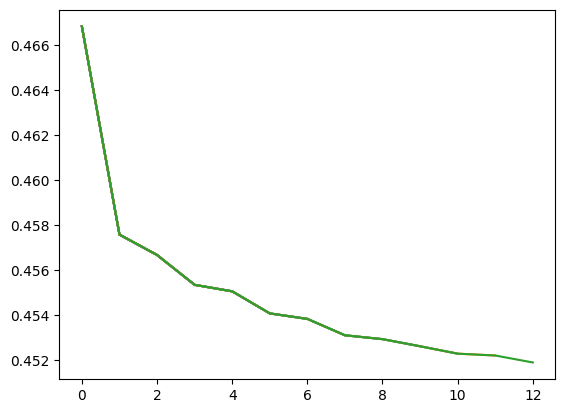

In [151]:
train(net, train_dataloader, loss_fn, opti, max_epoch, device)

In [ ]:
print(net.state_dict())

In [ ]:
def predict(net, X, device):
    net.eval()
    X = X.to(device)
    return (net(X) / 2 * max_abs) + means

In [152]:
for x, y in test_dataloader:
    print(np.concatenate((y.numpy(), predict(net, x, device).detach().cpu().numpy()), axis=1))
    break

[[ 2.3428817e-01 -2.8274067e-02]
 [-8.7814689e-01 -1.4593337e-02]
 [ 4.1419724e-01  1.1177838e-02]
 [-7.8855956e-01 -2.0313658e-02]
 [-6.0384476e-01  7.6169185e-02]
 [-5.0541514e-01 -5.4060169e-02]
 [ 4.7823712e-01 -5.1008351e-02]
 [ 7.6192153e-01 -3.0479543e-02]
 [ 4.1548070e-01 -4.5133807e-02]
 [ 4.3251511e-01  2.7865775e-02]
 [ 4.2724496e-01  2.6140014e-02]
 [-1.7196210e-01 -4.5220256e-03]
 [ 6.4820671e-01  2.2116676e-03]
 [-2.4881049e-01  2.7790278e-02]
 [ 5.5728948e-01 -3.8286574e-02]
 [ 7.3937273e-01  4.9384300e-02]
 [ 6.7640847e-01 -2.4571918e-02]
 [-5.9091288e-01  2.0243818e-02]
 [ 1.7478912e-01  3.0129138e-02]
 [ 6.2735564e-01 -5.3751096e-03]
 [-7.6413196e-01  1.3615549e-02]
 [ 1.7040710e-01 -1.3673797e-02]
 [ 3.6853737e-01 -2.0743735e-02]
 [-2.9326397e-01 -8.2057334e-02]
 [-7.5911999e-01  3.1432528e-02]
 [-6.7764318e-01  4.8195943e-03]
 [ 2.8584805e-01  2.0192757e-02]
 [-7.3774344e-01 -2.4689913e-02]
 [-7.0941353e-01 -4.7453493e-02]
 [ 4.4119683e-01 -1.0498613e-04]
 [-1.83357